In [1]:
import torch

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device)

False
학습을 진행하는 기기: cpu


/home/hshan/venvs/keras/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [3]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [4]:
seed_everything(42)

In [6]:
data = pd.read_csv('./data/public_data/train.csv')

In [8]:
data[5:15]

,date,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),...,청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
5,2016-01-06,수요일,1045507.5,442.0,1904372.1,409.0,1860569.0,1263.0,1672.0,7041.0,...,31081.4,5511.0,190011.0,2535.0,269894.2,2503.0,7487.0,2119.0,0.0,0.0
6,2016-01-07,목요일,1039925.0,448.0,1438990.2,428.0,1868011.7,1241.0,1191.0,3908.0,...,27873.6,4384.0,158516.0,2440.0,198854.0,2533.0,4687.8,2997.0,0.0,0.0
7,2016-01-08,금요일,942655.0,420.0,1563537.8,390.0,1483395.0,1218.0,672.4,4836.0,...,29272.8,3554.0,181992.0,2303.0,307436.6,2509.0,4916.0,2734.0,0.0,0.0
8,2016-01-09,토요일,689121.0,389.0,1723983.9,345.0,1107262.5,1210.0,5456.6,5112.0,...,31822.0,3095.0,164854.0,2035.0,191536.0,2436.0,1766.0,4773.0,0.0,0.0
9,2016-01-10,일요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2016-01-11,월요일,1161028.0,398.0,1940798.7,336.0,1651529.5,1215.0,73.0,5712.0,...,33310.8,3116.0,284347.0,2183.0,337420.0,2431.0,2039.8,2133.0,0.0,0.0
11,2016-01-12,화요일,730460.1,431.0,1748847.8,309.0,1606583.0,1161.0,6321.0,5498.0,...,27964.0,2656.0,143468.0,2153.0,194121.0,2562.0,920.0,3072.0,0.0,0.0
12,2016-01-13,수요일,642654.0,429.0,1416822.0,307.0,1211231.0,1166.0,758.8,6879.0,...,26757.0,2787.0,126107.0,2182.0,230051.0,2549.0,2674.8,2261.0,0.0,0.0
13,2016-01-14,목요일,777445.9,441.0,1412984.0,306.0,1313759.0,1148.0,1330.0,4350.0,...,22241.6,2952.0,159028.0,2166.0,170239.0,2728.0,1840.4,2567.0,0.0,0.0
14,2016-01-15,금요일,793655.0,449.0,1437415.0,307.0,1187834.0,1146.0,995.0,6643.0,...,26905.0,3195.0,171440.0,2163.0,254080.0,2820.0,836.4,6504.0,0.0,0.0


In [7]:
week_day_map = {}
for i, d in enumerate(data['요일'].unique()):
    week_day_map[d] = i
data['요일'] = data['요일'].map(week_day_map)

In [8]:
norm = data.iloc[:, 1:].max(0)
data.iloc[:, 1:] = data.iloc[:, 1:] / norm

In [26]:
# device = torch.device("cuda:0") # GPU 사용
device = torch.device("cpu")
target_n = 21 # 맞춰야하는 품목/품종의 수
learning_rate = 5e-4 # 학습률
BATCH_SIZE = 128 # 배치사이즈
EPOCHS = 5 # 총 eopochs
teacher_forcing = False # 교사강요 설정
n_layers = 3 # rnn레이어 층
dropout = 0.2 # 드롭아웃
window_size = 28 # 인코더 시퀀스 길이
future_size = 28 # 디코더 시퀀스 길이
hidden_dim = 128 # rnn 히든차원
save_path = f'./models/best_model.pt' # 모델 저장 경로

* to_numpy : pandas==0.24.0

In [27]:
x_data = []
y_data = []
for i in range(data.shape[0]-window_size-future_size):
    x = data.iloc[i:i+window_size, 1:].to_numpy()
    y = data.iloc[i+window_size:i+window_size+future_size, 3::2].to_numpy()
    y_0 = np.zeros([1, y.shape[1]]) # 디코더 첫 입력값 추가
    x_data.append(x)
    y_data.append(np.concatenate([y_0, y], axis=0))
x_data = np.array(x_data)
y_data = np.array(y_data)

In [28]:
x_data.shape, y_data.shape

((1677, 28, 43), (1677, 29, 21))

In [29]:
train_test_split = 1
x_train = x_data[:-train_test_split-future_size]
y_train = y_data[:-train_test_split-future_size]
x_val = x_data[-train_test_split:]
y_val = y_data[-train_test_split:]

In [30]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1648, 28, 43), (1648, 29, 21), (1, 28, 43), (1, 29, 21))

In [31]:
class CustomDataset(Dataset):
    def __init__(self, encoder_input, decoder_input):
        self.encoder_input = encoder_input
        self.decoder_input = decoder_input
        
    def __len__(self):
        return len(self.encoder_input)
    
    def __getitem__(self, i):
        return {
            'encoder_input' : torch.tensor(self.encoder_input[i], dtype=torch.float32),
            'decoder_input' : torch.tensor(self.decoder_input[i], dtype=torch.float32)
        }

In [32]:
train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=False)

In [33]:
sample_batch = next(iter(train_dataloader))

In [34]:
sample_batch['encoder_input'].shape, sample_batch['decoder_input'].shape

(torch.Size([128, 28, 43]), torch.Size([128, 29, 21]))

In [35]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.n_layers = n_layers
        
        self.rnn = nn.GRU(input_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp_seq):
        inp_seq = inp_seq.permute(1,0,2)
        outputs, hidden = self.rnn(inp_seq)
        
        return outputs, hidden

In [36]:
class BahdanauAttention(nn.Module):
    def __init__(self, dec_output_dim, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = nn.Linear(dec_output_dim, units)
        self.W2 = nn.Linear(dec_output_dim, units)
        self.V = nn.Linear(dec_output_dim, 1)

    def forward(self, hidden, enc_output):
        query_with_time_axis = hidden.unsqueeze(1)
        
        score = self.V(torch.tanh(self.W1(query_with_time_axis) + self.W2(enc_output)))
        
        attention_weights = torch.softmax(score, axis=1)
        
        context_vector = attention_weights * enc_output
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector, attention_weights

In [37]:
class Decoder(nn.Module):
    def __init__(self, dec_feature_size, encoder_hidden_dim, output_dim, decoder_hidden_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.n_layers = n_layers
        self.attention = attention
        
        self.layer = nn.Linear(dec_feature_size, encoder_hidden_dim)
        self.rnn = nn.GRU(encoder_hidden_dim*2, decoder_hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, enc_output, dec_input, hidden):
        dec_input = self.layer(dec_input)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        dec_input = torch.cat([torch.sum(context_vector, dim=0), dec_input], dim=1)
        dec_input = dec_input.unsqueeze(0)
        
        output, hidden = self.rnn(dec_input, hidden)

        prediction = self.fc_out(output.sum(0))
        
        return prediction, hidden

In [38]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, attention):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, encoder_input, decoder_input, teacher_forcing=False):
        batch_size = decoder_input.size(0)
        trg_len = decoder_input.size(1)
        
        outputs = torch.zeros(batch_size, trg_len-1, self.decoder.output_dim).to(device)
        enc_output, hidden = self.encoder(encoder_input)
        
        dec_input = decoder_input[:, 0]
        for t in range(1, trg_len):
            output, hidden = self.decoder(enc_output, dec_input, hidden)
            outputs[:, t-1] = output
            if teacher_forcing == True:
                dec_input = decoder_input[:, t]
            else:
                dec_input = output
        
        return outputs

In [39]:
encoder = Encoder(input_dim=x_data.shape[-1], hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout)
attention = BahdanauAttention(dec_output_dim=hidden_dim, units=hidden_dim)
decoder = Decoder(
    dec_feature_size=target_n, encoder_hidden_dim=hidden_dim, output_dim=target_n,
    decoder_hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout,
    attention = attention
)

model = Seq2Seq(encoder, decoder, attention)
model = model.to(device)


In [40]:
def my_custom_metric(pred, true):
    pred = pred[:, [6, 13, 27]]
    true = true[:, [6, 13, 27]]
    target = torch.where(true!=0)
    true = true[target]
    pred = pred[target]
    score = torch.mean(torch.abs((true-pred))/(true))
    
    return score

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss() # mae
custom_metric = my_custom_metric

In [42]:
def train_step(batch_item, epoch, batch, training, teacher_forcing):
    encoder_input = batch_item['encoder_input'].to(device)
    decoder_input = batch_item['decoder_input'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(encoder_input, decoder_input, teacher_forcing)
            loss = criterion(output, decoder_input[:,1:])
            score = custom_metric(output, decoder_input[:,1:])
        loss.backward()
        optimizer.step()
        
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(encoder_input, decoder_input, False)
            loss = criterion(output, decoder_input[:,1:])
            score = custom_metric(output, decoder_input[:,1:])
        return loss, score

In [43]:
loss_plot, val_loss_plot = [], []
score_plot, val_score_plot = [], []

for epoch in range(EPOCHS):
    total_loss, total_val_loss = 0, 0
    total_score, total_val_score = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_score = train_step(batch_item, epoch, batch, training, teacher_forcing)
        total_loss += batch_loss
        total_score += batch_score
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Score': '{:06f}'.format(batch_score.item()),
            'Total Score' : '{:06f}'.format(total_score/(batch+1)),
        })
    loss_plot.append(total_loss/(batch+1))
    score_plot.append(total_score/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_val_score = train_step(batch_item, epoch, batch, training, teacher_forcing)
        total_val_loss += batch_loss
        total_val_score += batch_val_score
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Val Score': '{:06f}'.format(batch_val_score.item()),
            'Total Val Score' : '{:06f}'.format(total_val_score/(batch+1)),
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_score_plot.append(total_val_score/(batch+1))
    
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, save_path)

0it [00:00, ?it/s]/home/hshan/venvs/keras/lib/python3.6/site-packages/torch/cuda/amp/autocast_mode.py:120: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
13it [00:04,  2.87it/s, Epoch=1, Loss=0.134064, Total Loss=0.170077, Score=0.359178, Total Score=0.535774]
1it [00:00,  2.64it/s, Epoch=1, Val Loss=0.249992, Total Val Loss=0.249992, Val Score=0.481573, Total Val Score=0.481573]
13it [00:05,  2.50it/s, Epoch=2, Loss=0.119985, Total Loss=0.127581, Score=0.325178, Total Score=0.355262]
1it [00:00,  1.59it/s, Epoch=2, Val Loss=0.215794, Total Val Loss=0.215794, Val Score=0.430230, Total Val Score=0.430230]
13it [00:05,  2.30it/s, Epoch=3, Loss=0.112681, Total Loss=0.117685, Score=0.290646, Total Score=0.312795]
1it [00:00,  1.22it/s, Epoch=3, Val Loss=0.194773, Total Val Loss=0.194773, Val Score=0.414039, Total Val Score=0.414039]
13

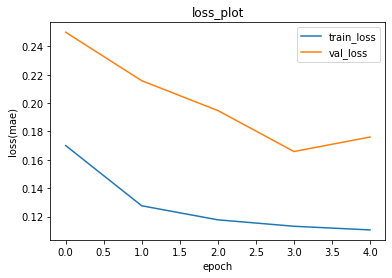

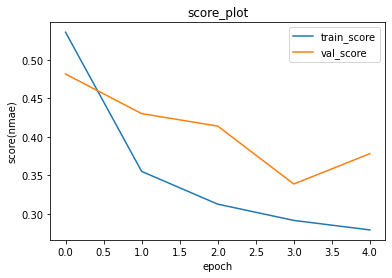

In [44]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.title('loss_plot')
plt.legend()
plt.show()

plt.plot(score_plot, label='train_score')
plt.plot(val_score_plot, label='val_score')
plt.xlabel('epoch')
plt.ylabel('score(nmae)')
plt.title('score_plot')
plt.legend()
plt.show()


In [45]:
model = torch.load(save_path)
model = model.to(device)

In [46]:
def predict(encoder_input):
    model.train()
    encoder_input = encoder_input.to(device)
    decoder_input = torch.zeros([1, future_size+1, target_n], dtype=torch.float32).to(device)
    with torch.no_grad():
        output = model(encoder_input, decoder_input, False)
    return output.cpu()

In [47]:
submission = pd.read_csv('./data/sample_submission.csv')


In [48]:
public_date_list = submission[submission['예측대상일자'].str.contains('2020')]['예측대상일자'].str.split('+').str[0].unique()


In [49]:
outputs = []
troch_norm = torch.tensor(norm.to_numpy()[2::2])
for date in public_date_list:
    test_df = pd.read_csv(f'./data/public_data/test_files/test_{date}.csv')
    data = pd.read_csv('./data/public_data/train.csv')
    data = pd.concat([data, test_df]).iloc[-window_size:]
    
    week_day_map = {}
    for i, d in enumerate(data['요일'].unique()):
        week_day_map[d] = i
    data['요일'] = data['요일'].map(week_day_map)
    data = data.iloc[:,1:]/norm
    
    encoder_input = torch.tensor(data.to_numpy(), dtype=torch.float32)
    encoder_input = encoder_input.unsqueeze(0)
    output = predict(encoder_input)*troch_norm
    
    idx = submission[submission['예측대상일자'].str.contains(date)].index
    submission.loc[idx, '배추_가격(원/kg)':] = output[0,[6,13,27]].numpy()

In [50]:
submission.to_csv('dacon_baseline.csv', index=False)
